In [1]:
import torch
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import bliss

import bliss.models.encoder as encoder_lib
from bliss.models.decoder import ImageDecoder
from bliss.models import galaxy_net

from bliss import device, use_cuda
print(device)
print(use_cuda)

data_path = Path('../data/')

cuda
True


In [3]:
torch.manual_seed(2342)
np.random.seed(354)

# Model parameters

In [4]:
n_bands = 1
slen = 12

In [5]:
# background
background = torch.zeros(n_bands, slen, slen, device=device)
background[:] = 0.

In [6]:
# psf parameters 
psf_file = data_path.joinpath("fitted_powerlaw_psf_params.npy")
psf_params = torch.from_numpy(np.load(psf_file)).to(device)[0:n_bands]

### Get galaxy decoder

In [7]:
simulate_galaxy = True
if simulate_galaxy: 
    assert n_bands == 1, 'galaxy decoder only available for single band'
    gal_slen = 51
    latent_dim = 8
    decoder_file = '../data/galaxy_decoder_1_band.dat'
    dec = galaxy_net.CenteredGalaxyDecoder(gal_slen, latent_dim, n_bands=n_bands).to(device)
    dec.load_state_dict(torch.load(decoder_file, map_location=device))
    dec.eval()
    prob_galaxy = 1.
else: 
    dec = None
    prob_galaxy = 0.

# Define decoder

In [8]:
# false for debugging
add_noise = False

In [9]:
image_decoder = ImageDecoder(dec,
                        psf_params,
                        background,
                        n_bands=n_bands,
                        slen=slen,
                        prob_galaxy=prob_galaxy,
                        max_sources=2,
                        mean_sources=2,
                        min_sources=2,
                        f_min=1e4,
                        f_max=1e6,
                        alpha=0.5,
                        add_noise=add_noise)

# Set parameters

In [10]:
batch_size = 3

In [11]:
params = image_decoder.sample_parameters(batch_size)

In [12]:
params['locs'].shape

torch.Size([3, 2, 2])

In [14]:
params['galaxy_params'].shape

torch.Size([3, 2, 8])

In [19]:
image_decoder.galaxy_decoder(params['galaxy_params'].reshape(-1, image_decoder.latent_dim))[0].shape

torch.Size([6, 1, 51, 51])

In [32]:
# specify first location
x0 = 2.5
x1 = 2.5
params['locs'][:, :, 0] =  x0 / slen
params['locs'][:, :, 1] =  x1 / slen

In [33]:
params['locs']

tensor([[[0.2083, 0.2083],
         [0.2083, 0.2083]],

        [[0.2083, 0.2083],
         [0.2083, 0.2083]],

        [[0.2083, 0.2083],
         [0.2083, 0.2083]]], device='cuda:0')

# Render image

In [27]:
image1 = image_decoder.render_images(
                            image_decoder.max_sources,
                            params['n_sources'],
                            params['locs'],
                            params['galaxy_bool'],
                            params['galaxy_params'],
                            params['fluxes'])


torch.Size([3, 1, 51, 51])


## Set new location and re-render

In [16]:
# the second location
locs2 = params['locs'] * 0.0

shift0 = 3
shift1 = 5
locs2[:, :, 0] = (x0 + shift0) / slen
locs2[:, :, 1] = (x1 + shift1) / slen

# render second image
image2 = image_decoder.render_images(
                            image_decoder.max_sources, 
                            params['n_sources'],
                            locs2, 
                            params['galaxy_bool'],
                            params['galaxy_params'],
                            params['fluxes'])


torch.Size([1, 1, 51, 51])


In [17]:
locs2

tensor([[[0.4583, 0.6250]]], device='cuda:0')

### Plot

In [18]:
batch = 0
band = 0

In [19]:
%matplotlib inline

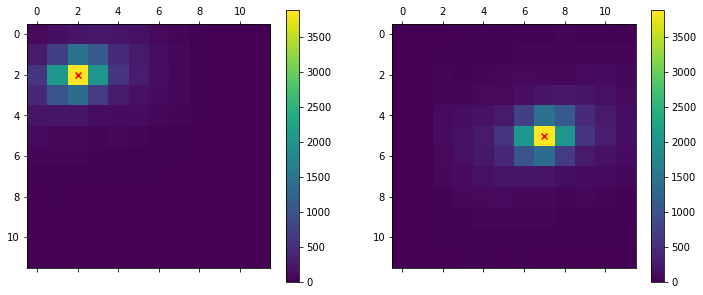

In [20]:
f, axarr = plt.subplots(1, 2, figsize=(12, 5))

# plot image
ax0 = axarr[0].matshow(image1[batch, band].cpu().detach())
ax1 = axarr[1].matshow(image2[batch, band].cpu().detach())

f.colorbar(ax0, ax = axarr[0])
f.colorbar(ax1, ax = axarr[1])

# plot locations 
axarr[0].scatter(params['locs'][batch, :, 1].cpu() * slen - 0.5, 
              params['locs'][batch, :, 0].cpu() * slen - 0.5, 
              color = 'red', marker = 'x')
axarr[1].scatter(locs2[batch, :, 1].cpu() * slen - 0.5, 
              locs2[batch, :, 0].cpu() * slen - 0.5, 
              color = 'red', marker = 'x')


# Check difference in shifts

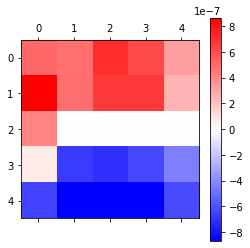

In [21]:
check_slen = 5

im1 = image1[batch, :, 0:check_slen, 0:check_slen] 
im2 = image2[batch, :, shift0:(shift0 + check_slen), shift1:(shift1 + check_slen)]

diff = (im1 - im2) / im1

vmax = diff.max().abs()
plt.matshow(diff[batch].cpu().detach(), cmap = plt.get_cmap('bwr'), vmax = vmax, vmin = -vmax)
plt.colorbar()